# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №1 - Метод k-средних, предобработка признаков


# <hr\>
**Общая информация**

**Срок сдачи:** до 7 октября 2017, 06:00   
**Штраф за опоздание:** -2 балла после 06:00 7 октября, -4 балла после 06:00 14 октября, -6 баллов после 06:00 21 октября

При отправлении ДЗ указывайте фамилию в названии файла   


Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush
Необходимо в slack создать таск в приватный чат:   
/todo Фамилия Имя *ссылка на гитхаб* @alkhamush   
Пример:   
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush   

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

# Первое задание - указать фамилию в имени файла

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.spatial.distance import euclidean

from __future__ import division, print_function

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 5)

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.  
При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди аттрибутов класса `Kmeans` должны появиться:
* Метки кластеров для объектов
* Координаты центроидов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

###### Задание 1 (2 баллов)
Имплементируйте метод k-means

Теория для выполнения задания 2 и 3 остаётся на самостоятельное изучение. Теории немного и она совсем простая.

###### Задание 2 (2 балла)
Имплементируйте класс MiniBatchKMeans, который является классом наследником Kmeans.

###### Задание 3 (2 балла)
Превратите k-means в k-means++. Для этого нужно реализовать метод в классе Kmeans, который будет инициализировать более "хорошие" значения центроидов. Чтобы использовался метод k-means++, в параметр init необходимо передать строковое значение 'k-means' (по умолчанию 'random').

###### Задание 4 (2 балла)
В пункте "Проверка корректности метода" нужно нарисовать графики, которые показывают зависимость времени выполнения алгоритма от количества сэмплов. Графики должны быть  нарисованы для различных комбинаций реализаций алгоритма (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). Для этого рекомендуется использовать инструмент %timeit. График достаточно построить на 5-10 точках.

###### Задание 5 (2 балла)
В пункте "Применение K-means на реальных данных" нужно сравнить различные реализации k-means (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). После чего написать вывод, в котором должно быть объяснение того, почему один алгоритм оказался лучше остальных или почему не было выявлено лучшего алгоритма.

In [2]:
from sklearn.base import ClusterMixin
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
from copy import copy

class Kmeans(BaseEstimator, ClusterMixin): 
   
    # 2-D визуализация.
    def plot(self, X, y):

        plt.figure(figsize=(6, 6));
        plt.xlim([-10, 10])
        plt.ylim([-10, 10])  
        plt.grid()
                
        Centroids = np.array(self.centroids)
        plt.scatter(X[:, 0], X[:, 1], c = y)
        plt.scatter(Centroids[:, 0], Centroids[:, 1], marker='*', s=169, linewidths=2, color='r', zorder=10)
        
    # Возвращает центроиды.
    def centroids(self):
        
        return self.centroids
    
    def __init__(self, k=3, metric='euclidean', max_iter=1000, random_state=2, init='random'):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """
        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        self.init = init

    # Процедура обучения k-means. 
    def fit(self, X, y=None):
     
        # Инициализация генератора случайных чисел.
        np.random.seed(self.random_state)
        
        # Массив с метками кластеров для каждого объекта из X.
        self.labels = np.empty(X.shape[0])

        # Массив с центроидами кластеров.
        self.centroids = np.empty((self.k, X.shape[1]))
        
        if self.init == 'random':
            # Выбор k точек из имеющихся.
            # self.centroids = X[np.random.choice(len(X), self.k)] 
            
            # Идея: чем ближе друг к другу начальные положения центроидов, тем больше вероятность, что 
            # все центроиды найдут свои точки. Для разных данных можно варьировать диапазон (здесь: [-0.5, 0.5])
            self.centroids = 1 * np.random.random_sample((self.k, X.shape[1])) - 0.5

        elif self.init == 'k-means':
            # Произвольный выбор одной из имеющихся точек в качестве первого центроида.
            self.centroids[0] = X[np.random.choice(len(X), 1)]
            
            # https://www.wikiwand.com/ru/K-means%2B%2B
            for j in range(1, self.k):
                # Для каждой точки найти значение квадрата расстояния до ближайшего 
                # центроида (из тех, которые уже выбраны) dx².
                d_x2 = np.array(np.min(cdist(X, self.centroids[:j]) ** 2, axis = 1))
                # d_x2 = np.array([np.min([np.linalg.norm(point - centr) for centr in self.centroids[:j]]) ** 2 for point in X])
                
                # Выбрать из этих точек следующий центроид так, чтобы вероятность выбора точки 
                # была пропорциональна вычисленному для неё квадрату расстояния. 
                Sum = np.sum(d_x2) * np.random.rand()
                Sum2 = 0
            
                for i in range(len(X)):

                    Sum2 += d_x2[i]
                    
                    if Sum2 > Sum:
                        self.centroids[j] = X[i]
                        break 
        
        # Для прекращения итерирования в случае сходимости.
        eps = 1e-10
        
        for it in range(self.max_iter):
            
            # Для сравнения с eps сохраняем положение центроидов на предыдущей итерации.
            old_centroids = copy(self.centroids)

            self.labels = np.array(np.argmin(cdist(X, self.centroids), axis = 1))
            # self.labels = np.array([np.argmin([np.sqrt(np.sum((centr - point)**2)) for centr in self.centroids]) for point in X])
        
            control_dist = 0
            
            for i in range(self.k):
                # Пересчёт центроидов.
                self.centroids[i] = np.mean(X[self.labels == i], axis = 0)
                # Суммарное расстояние, на которое переместились все центроиды за одну итерацию.
                control_dist += euclidean(old_centroids[i], self.centroids[i])
           
            if control_dist < eps:
                return self
        
        return self

        
    # Возвращает метку ближайшего кластера для каждого объекта.
    def predict(self, X, y=None):
        
        self.labels = np.array(np.argmin(cdist(X, self.centroids), axis = 1))
        # self.labels = np.array([np.argmin([np.sqrt(np.sum((centr - point)**2)) for centr in self.centroids]) for point in X])
        return self.labels


In [3]:
class MiniBatchKMeans(Kmeans):
    def __init__(self, k=3, b=20, metric='euclidean', max_iter=1000, random_state=1, init='random'):
        
        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        self.init = init
        # + batch size.
        self.b = b
        
        
    def fit(self, X, y=None):
        
        # Инициализация генератора случайных чисел.
        np.random.seed(self.random_state)
        
        # Массив с метками кластеров для каждого объекта из X.
        self.labels = np.empty(X.shape[0])

        # Массив с центроидами кластеров.
        self.centroids = np.empty((self.k, X.shape[1]))
        
        if self.init == 'random':
            # Выбор k точек из имеющихся.
            # self.centroids = X[np.random.choice(len(X), self.k)] 
            
            # Идея: чем ближе друг к другу начальные положения центроидов, тем больше вероятность, что 
            # все центроиды найдут свои точки. Для разных данных можно варьировать диапазон (здесь: [-0.5, 0.5])
            self.centroids = 1 * np.random.random_sample((self.k, X.shape[1])) - 0.5
            
        elif self.init == 'k-means':
            # Произвольный выбор одной из имеющихся точек в качестве первого центроида.
            self.centroids[0] = X[np.random.choice(len(X), 1)]
            
            # https://www.wikiwand.com/ru/K-means%2B%2B
            for j in range(1, self.k):
                # Для каждой точки найти значение квадрата расстояния до ближайшего 
                # центроида (из тех, которые уже выбраны) dx².
                d_x2 = np.array(np.min(cdist(X, self.centroids[:j]) ** 2, axis = 1))
                # d_x2 = np.array([np.min([np.linalg.norm(point - centr) for centr in self.centroids[:j]]) ** 2 for point in X])
                
                # Выбрать из этих точек следующий центроид так, чтобы вероятность выбора точки 
                # была пропорциональна вычисленному для неё квадрату расстояния. 
                Sum = np.sum(d_x2) * np.random.rand()
                Sum2 = 0
            
                for i in range(len(X)):
                    
                    Sum2 += d_x2[i]
                    
                    if Sum2 > Sum:
                        self.centroids[j] = X[i]
                        break
        
        # Для прекращения итерирования в случае сходимости.
        eps = 1e-10
        
        for it in range(self.max_iter):
            
            # Выбор b точек.
            b_Points = X[np.random.choice(len(X), self.b)]
            
            # Для сравнения с eps сохраняем положение центроидов на предыдущей итерации.
            old_centroids = copy(self.centroids)
            
            self.labels = np.array(np.argmin(cdist(b_Points, self.centroids), axis = 1))

            control_dist = 0

            # Хранение координат точек из mini-batch, принадлежащих разным кластерам.
            cluster_points = [[]] * self.k
            
            for j in range(len(b_Points)):
                
                i = self.labels[j]
                cluster_points[i].append(b_Points[j])
                
                # Итеративный метод нахождения центра масс системы b точек с весами n и (1 - n).
                n = 1 / len(cluster_points[i])
                self.centroids[i] = (1 - n) * self.centroids[i] + n * b_Points[j]
            
            for j in range(self.k):
                
                # Суммарное расстояние, на которое переместились все центроиды.
                control_dist += euclidean(old_centroids[j], self.centroids[j])
      
            # Проверка на сходимость.
            if control_dist < eps:
                return self
        
        return self


### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, нужно испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

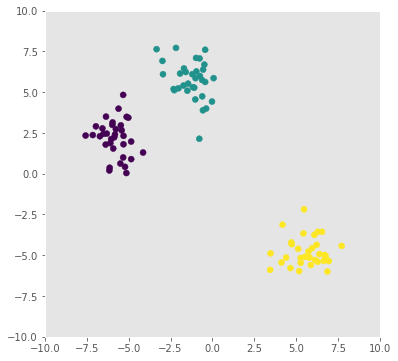

In [4]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
                       center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

plt.figure(figsize=(6, 6));
plt.xlim([-10, 10])
plt.ylim([-10, 10])     
plt.grid()

plt.scatter(X[:, 0], X[:, 1], c=y);


Проверьте Вашу имплементацию на простых данных (без этого пункта задание не считается выполненным).   
КОММЕНТАРИИ НЕ СТИРАТЬ!

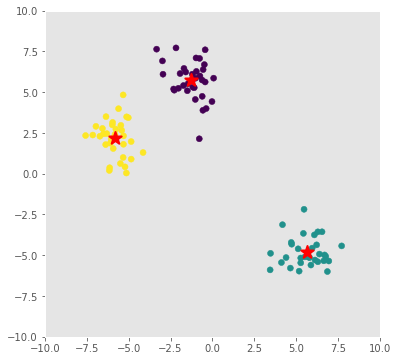

In [5]:
## Работоспособность KMeans

model = Kmeans(random_state=139, init='random')
model.fit(X)
Centroids = model.predict(X)

model.plot(X, Centroids)

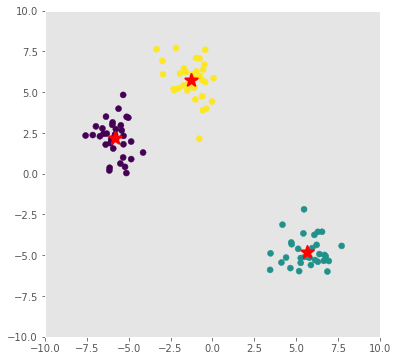

In [6]:
## Работоспособность KMeans++

model_Kpp = Kmeans(random_state=139, init='k-means')
model_Kpp.fit(X)
Centroids = model_Kpp.predict(X)

model_Kpp.plot(X, Centroids)

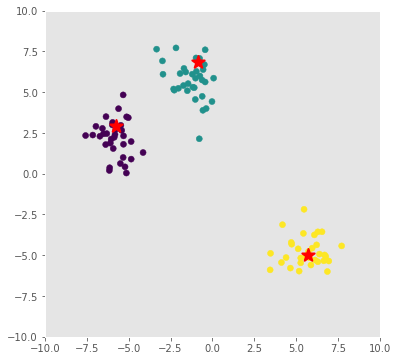

In [7]:
## Работоспособность KMeans с MiniBatchKMeans

model_MBK = MiniBatchKMeans(random_state=1234, init='random')
model_MBK.fit(X)
Centroids = model_MBK.predict(X)

model_MBK.plot(X, Centroids)

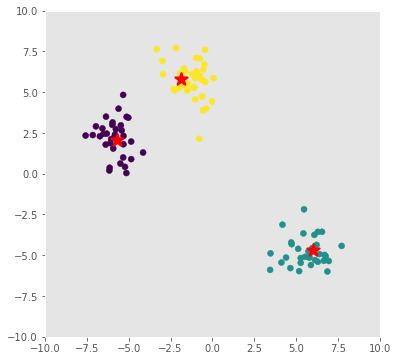

In [8]:
## Работоспособность KMeans++ с MiniBatchKMeans

model_MBKpp = MiniBatchKMeans(random_state=139, init='k-means')
model_MBKpp.fit(X)
Centroids = model_MBKpp.predict(X)

model_MBKpp.plot(X, Centroids)

На игрушечных данных разбиение верное, однако, видно, что центроиды в случае использования части выборки иногда располагаются относительно далеко от соответствующих центров масс кластеров.

### Время выполнения алгоритмов

10 loops, best of 3: 1.57 ms per loop
10 loops, best of 3: 1.82 ms per loop
10 loops, best of 3: 1.11 ms per loop
10 loops, best of 3: 1.01 ms per loop
10 loops, best of 3: 1.04 ms per loop


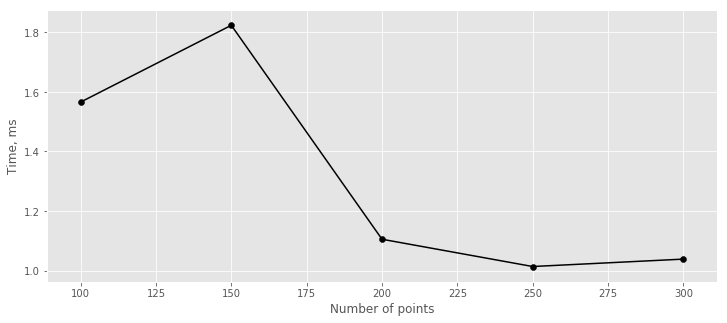

In [9]:
## Время выполнения алгоритма KMeans

numList = [100 + 50 * x for x in range(5)]
timeList = []

for n in numList:
    Points, y = make_blobs(n_samples=n, n_features=2, centers=3, cluster_std=1, 
                       center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    model = Kmeans(k=3, random_state=1234, init='random')
    result = %%timeit -n 10 -o model.fit(X)
    timeList.append(result.best * 1000)

plt.plot(numList, timeList, c='k')
plt.scatter(numList, timeList, c='k')
plt.xlabel('Number of points')
plt.ylabel('Time, ms')
plt.show()

10 loops, best of 3: 4.69 ms per loop
10 loops, best of 3: 2.83 ms per loop
10 loops, best of 3: 1.69 ms per loop
10 loops, best of 3: 5.56 ms per loop
10 loops, best of 3: 2.02 ms per loop


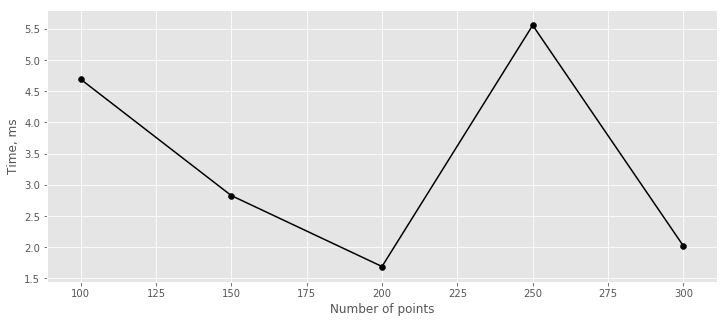

In [10]:
## Время выполнения алгоритма KMeans++

numList = [100 + 50 * x for x in range(5)]
timeList = []

for n in numList:
    Points, y = make_blobs(n_samples=n, n_features=2, centers=3, cluster_std=1, 
                       center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    model = Kmeans(k=3, random_state=1234, init='k-means')
    result = %%timeit -n 10 -o model.fit(Points)
    timeList.append(result.best * 1000)

plt.plot(numList, timeList, c='k')
plt.scatter(numList, timeList, c='k')
plt.xlabel('Number of points')
plt.ylabel('Time, ms')
plt.show()

The slowest run took 4.19 times longer than the fastest. This could mean that an intermediate result is being cached.
10 loops, best of 3: 239 ms per loop
The slowest run took 4.40 times longer than the fastest. This could mean that an intermediate result is being cached.
10 loops, best of 3: 213 ms per loop
10 loops, best of 3: 476 ms per loop
10 loops, best of 3: 445 ms per loop
10 loops, best of 3: 296 ms per loop


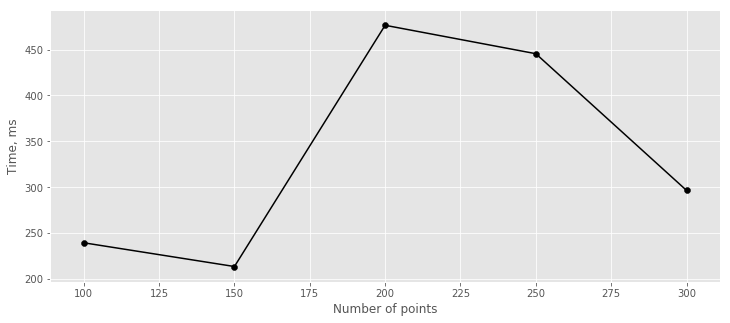

In [12]:
## Время выполнения алгоритма KMeans с MiniBatchKMeans

numList = [100 + 50 * x for x in range(5)]
timeList = []

for n in numList:
    Points, y = make_blobs(n_samples=n, n_features=2, centers=3, cluster_std=1, 
                       center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    model = MiniBatchKMeans(k=3, random_state=1234, init='random')
    result = %%timeit -n 10 -o model.fit(Points)
    timeList.append(result.best * 1000)

plt.plot(numList, timeList, c='k')
plt.scatter(numList, timeList, c='k')
plt.xlabel('Number of points')
plt.ylabel('Time, ms')
plt.show()

10 loops, best of 3: 443 ms per loop
10 loops, best of 3: 369 ms per loop
10 loops, best of 3: 311 ms per loop
10 loops, best of 3: 432 ms per loop
10 loops, best of 3: 456 ms per loop


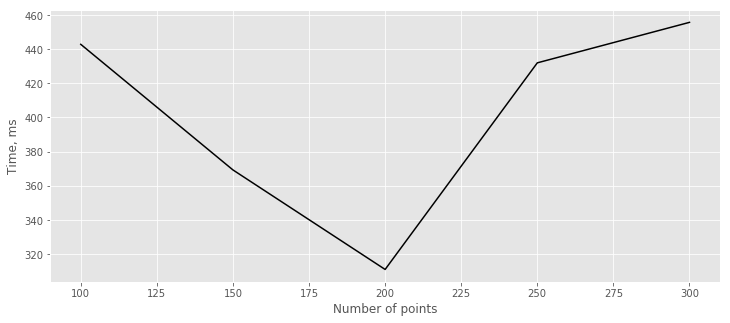

In [13]:
## Время выполнения алгоритма KMeans++ с MiniBatchKMeans

numList = [100 + 50 * x for x in range(5)]
timeList = []

for n in numList:
    Points, y = make_blobs(n_samples=n, n_features=2, centers=3, cluster_std=1, 
                       center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    model = MiniBatchKMeans(k=3, random_state=1234, init='k-means')
    result = %%timeit -n 10 -o model.fit(Points)
    timeList.append(result.best * 1000)

plt.plot(numList, timeList, c='k')
plt.xlabel('Number of points')
plt.ylabel('Time, ms')
plt.show()

Из полученных значений видно, что алгоритмы MiniBatchKmeans и MiniBatchKmeans++ работают значительно медленнее, что, в первую очередь, объясняется тем, что приведенные ранее данные являются достаточно простыми, и кластеризация первыми двумя способами происходит за гораздо меньшее число итераций, и для большей точности необходим более корректный подбор параметра b. При этом стоит отметить, что Kmeans++ работает быстрее.

# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.  (без этого пункта задание не считается выполненным).   
ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!


Данные устроены так:

* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [14]:
df_sns = pd.read_csv('snsdata.csv', sep=',')

# Оставляем только необходимые признаки.
df_sns = df_sns.drop(['gradyear', 'gender', 'age', 'friends'], axis = 1);

# Нормировка.
for i in df_sns.columns:
    df_sns[i] = (df_sns[i] - df_sns[i].mean()) / df_sns[i].std()


Wall time: 4.67 s


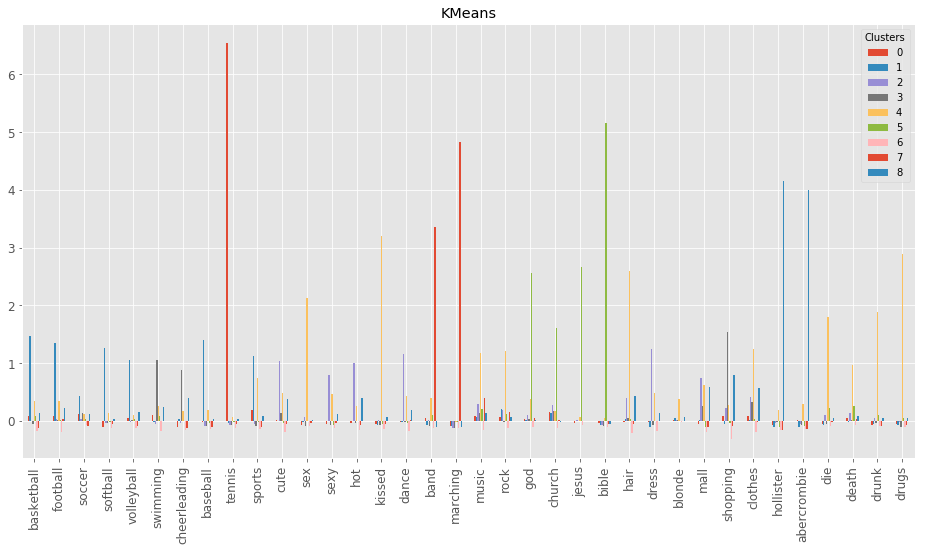

In [15]:
%%time

## Kmeans

df = pd.DataFrame.copy(df_sns)
K = Kmeans(k = 9, random_state = 1234)
K.fit(df.values)

df['Clusters'] = K.predict(df.values)
grouped = df.groupby('Clusters').mean()
grouped.transpose().plot.bar(use_index = True, title='KMeans', figsize=(16,8), fontsize=12);

Видно, что хорошо выделяются кластеры (не в указанном порядке): 
1. спортсмены (видимо американцы, так как это два их самых популярных вида спорта): {basketball, football (американский)};
2. спортсмены: {спорт, софтбол, волейбол, бейсбол, соккер ("европейский" футбол)};
3. теннисисты;
4. любители музыки: {band, marching};
5. верующие: {god, church, jesus, bible};
6. любители, в частности, брендовой одежды {hollister, abercrombie, shopping, clothes, hair, mall};
7. "тусовщики": {sexy, hot, dance, cute, dress}
8. еще более жесткие "тусовщики": {sex, sexy, kissed, music, rock, die, death, drunk, drugs}
9. ну и "розовые" - девчонки: {dance, dress}

Wall time: 5.22 s


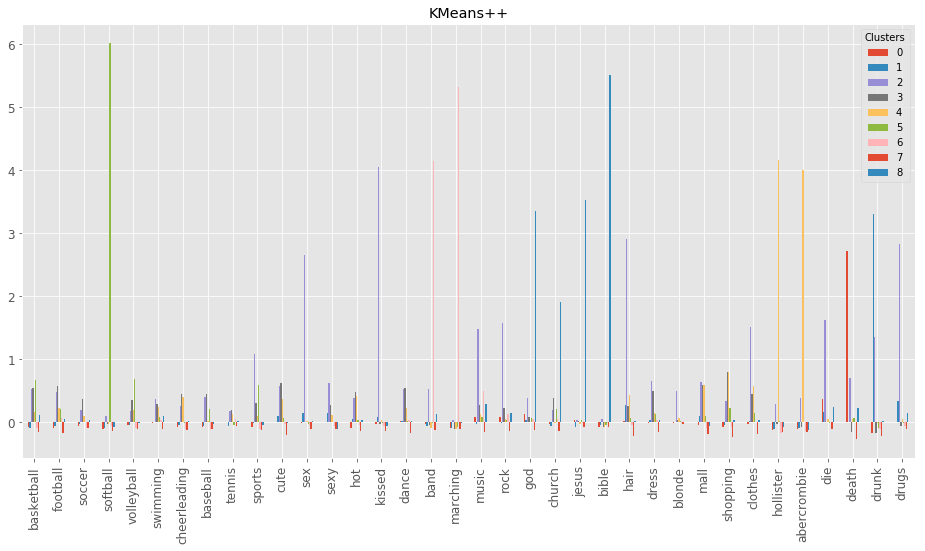

In [16]:
%%time

## KMeans++

df = pd.DataFrame.copy(df_sns)
Kpp = Kmeans(k = 9, random_state = 1234, init = 'k-means')
Kpp.fit(df.values)

df['Clusters'] = Kpp.predict(df.values)
grouped = df.groupby('Clusters').mean()
grouped.transpose().plot.bar(use_index = True, title='KMeans++', figsize=(16,8), fontsize=12);

Снова выделяются несколько очевидных кластеров:

1. Спортсмены: softball, basketball, volleyball, sports;
2. Тусовщики: kissed, sex, music, drugs, rock, sexy, die;
3. Модники: hollister, abercrombie, mall, clothes;
4. Верующие: bible, jesus, church, god;
5. Любители оркестров и марширования: band, marching;
6. Серо-коричневый молодёжный кластер - всего понемногу: виды спорта, танцы, покупки;
7. Явно выделяется кластер death.

Wall time: 2.76 s


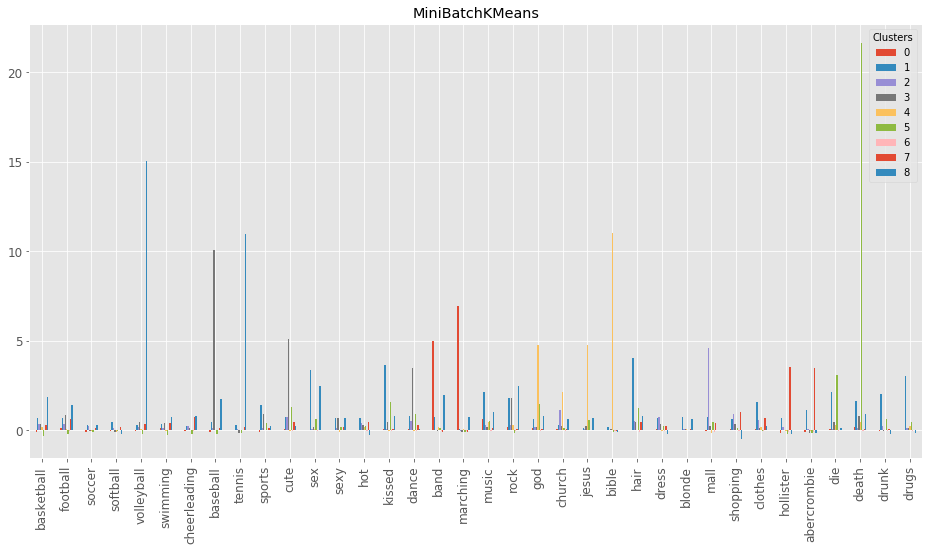

In [17]:
%%time

## KMeans с MiniBatchKMeans

df = pd.DataFrame.copy(df_sns)
MBK = MiniBatchKMeans(k = 9, b = 50, random_state = 10)
MBK.fit(df.values)

df['Clusters'] = MBK.predict(df.values)
grouped = df.groupby('Clusters').mean()
grouped.transpose().plot.bar(use_index = True, title='MiniBatchKMeans', figsize=(16,8), fontsize=12);

Снова выделяются:
1. Верующие (god, church, jesus, bible)
2. Оркестровые музыканты (band, marching)
3. Любители приодеться (hollister, abercrombie, shopping)
4. Потенциальные самоубийцы? (die, death)
5. Спортсмены (volleyball, tennis, basketball)
6. Тусовщики (sex, kissed, music, rock, hair, clothes, drunk)

Wall time: 2.52 s


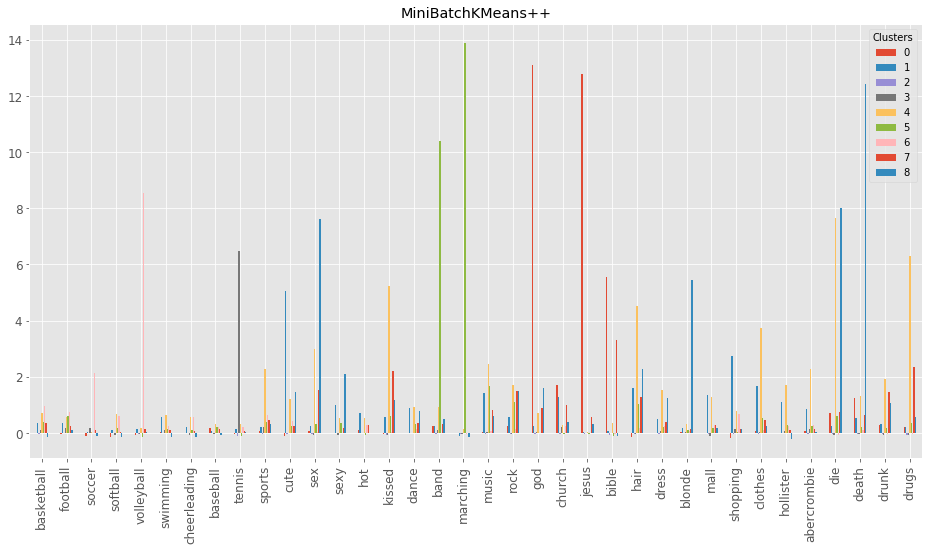

In [18]:
%%time

## KMeans++ с MiniBatchKMeans

df = pd.DataFrame.copy(df_sns)
MBKpp = MiniBatchKMeans(k = 9, random_state = 33232, init = 'k-means')
MBKpp.fit(df.values)

df['Clusters'] = MBKpp.predict(df.values)
grouped = df.groupby('Clusters').mean()
grouped.transpose().plot.bar(use_index = True, title='MiniBatchKMeans++', figsize=(16,8), fontsize=12);

1. Tennis
2. Volleyball, soccer
3. Band, marching
4. God, church, jesus, bible
5. Kissed, drunk, drugs, clothes, hollister, abercrombie, sports - молодежь


In [207]:
# X = pd.read_csv('snsdata.csv', sep=',')

# # Оставляем 36 необходимых признаков.
# X = X.drop(['gradyear', 'gender', 'age', 'friends'], axis = 1);

# # Нормировка.
# for i in X.columns:
#     X[i] = (X[i] - X[i].mean(axis=0)) / X[i].std(axis=0)

# # Разделение на 9 кластеров с помощью алгоритма Kmeans.
# %time clusters = Kmeans(k=9).fit(np.array(X.dropna()))
# clustered = pd.concat([X.dropna(), pd.DataFrame(clusters.labels, columns=["cluster"])],axis=1) 
# # clustered.head()
# print (clustered.groupby("cluster").apply(lambda x: x.set_index("cluster").mean().nlargest(5)))
# print (clustered.groupby("cluster").apply(lambda x: x.count().values[0]))

По итогам выполненной работы можно сделать несколько выводов:

_1. Метод mini-batch ускоряет время выполнения программы, при этом интерпретация получаемых кластеров немного усложняется, и выделяются наиболее очевидные;

_2. При соответствующем выборе параметров кластеризации можно выделить основные кластеры:
 - Спортсмены
 - Верующие
 - Тусовщики
 - Модники
 - Любители оркестровой музыки и маршей


_3. mini batch в каждой итерации использует только некоторую часть выборки, что, как мы убедились, может быть критично, поэтому в случае, если время выполнения не сильно отличается, стоит использовать классический метод kmeans.